In [1]:
import LibsControl
import numpy
import matplotlib.pyplot as plt

#parameters from identification
u_max       = 1.0      #max RPM controll
rpm_max     = 1400     #rpm on max current
rpm_var     = 1229     #rpm variance, encoder noise
tau         = 0.010    #10ms, motor time constant

#sampling frequency, 4kHz
dt       = 1.0/4000.0

rad_max = (rpm_max/60.0)*(2.0*numpy.pi) #rpm to rad/s
rad_var = (rpm_var/60.0)*(2.0*numpy.pi) #rpm to rad/s


#continuous time dynamics
mat_a = numpy.zeros((1, 1))
mat_b = numpy.zeros((1, 1))
mat_c = numpy.eye(1)
 
mat_a[0][0] = -1.0/tau    
mat_b[0][0] = (rad_max/u_max)*(1.0/tau)


print("continuous model")
print(mat_a)
print(mat_b)
print()



#create dynamical system
ds = LibsControl.DynamicalSystem(mat_a, mat_b, mat_c, dt)


#create loss weighting matrices (diagonal)
q = numpy.array([ [1.0] ] )
r = numpy.array( [ [1000000.0] ]) 

#process and observation noise covariance
q_noise = 0.1*numpy.eye(ds.a.shape[0]) 
r_noise = rad_var*numpy.eye(ds.c.shape[0]) 
 

a_disc, b_disc, c_disc = LibsControl.c2d(ds.a, ds.b, ds.c, dt)

print("discrete model")
print(a_disc)
print(b_disc)
print()


#solve LQG controller
lqg = LibsControl.LQGDiscrete(a_disc, b_disc, c_disc, q, r, q_noise, r_noise)

print("controller")
print("k  = ", lqg.k)
print("ki = ", lqg.ki)
print("f  = ", lqg.f)



continuous model
[[-100.]]
[[14660.76571675]]

discrete model
[[0.97530864]]
[[3.61994215]]

controller
k  =  [[0.01831874]]
ki =  [[0.00103262]]
f  =  [[0.01262243]]


<Figure size 640x480 with 0 Axes>

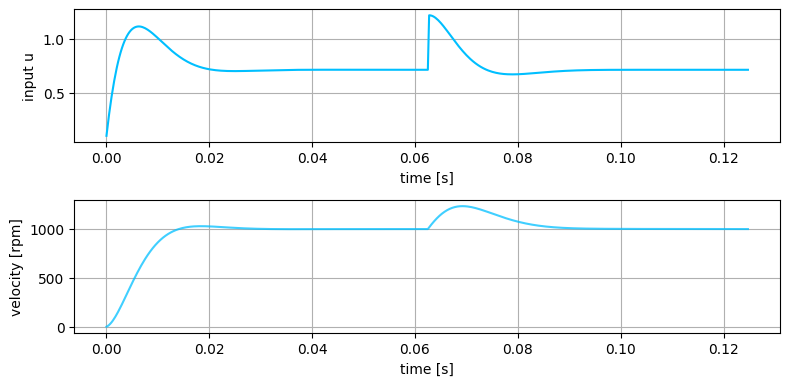

In [2]:

#process simulation

n_max = 500

#required output, 1000rpm
rpm_req = 1000

yr = numpy.zeros((mat_c.shape[0], 1))
yr[0][0] = (rpm_req/60.0)*(2.0*numpy.pi) 


#observed state
x_hat = numpy.zeros((mat_a.shape[0], 1))



#initial error integral
integral_action = numpy.zeros((mat_b.shape[1], 1))

#result log
t_result = []
u_result = []
x_result = []



#initial motor state
ds.reset()

#plant output
y = ds.y

for n in range(n_max):

    #compute controller output
    u, integral_action, x_hat = lqg.forward(yr, y, integral_action, x_hat)
    
    #add constant disturbance in middle
    if n > n_max//2:
        u[0]+= 0.5

    #compute plant output
    x, y = ds.forward_state(u)
  
    

    t_result.append(n*dt)
    u_result.append(u[:, 0].copy())
    x_result.append(x[:, 0].copy())

    
    
t_result = numpy.array(t_result)
x_result = numpy.array(x_result)
u_result = numpy.array(u_result)

#convert rps to rpm
x_result[:, 0]*= 60.0/(2.0*numpy.pi)

#plot results
LibsControl.plot_closed_loop_response(t_result, u_result, x_result, x_hat = None, file_name = "lqg_discrete_output.png", u_labels = ["input u"], x_labels = ["velocity [rpm]"])
